# Time Series of Energy stocks: Tensorflow

# 1. Energy stocks

# Category I (oil and gas only):
<font color='blue'>XOM (EXXONMOBIL/oil & gas)  
    
<font color='green'>DVN (DEVON/oil & gas)
    
# Category II (electricity):

<font color='orange'>EXC (EXELON /electricity)
    
<font color='red'>D (Dominion /electricity, gas & oil) 

In [20]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));


/kaggle: ['lib', 'input', 'working']
/kaggle/working: ['__notebook_source__.ipynb']


# 2. EDA

In [21]:
# import all stock prices 
df = pd.read_csv("../input/prices-split-adjusted.csv", index_col = 0)

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))



number of different stocks:  501


In [22]:
df.columns

Index(['symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')

In [23]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [24]:
df[df.symbol == 'XOM'].head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,XOM,68.720001,69.150002,68.190002,69.260002,27809100.0
2010-01-05,XOM,69.190002,69.419998,68.800003,69.449997,30174700.0
2010-01-06,XOM,69.449997,70.019997,69.339996,70.599998,35044700.0
2010-01-07,XOM,69.900002,69.800003,69.419998,70.059998,27192100.0
2010-01-08,XOM,69.690002,69.519997,69.220001,69.750000,24891800.0


In [25]:
df[df.symbol == 'XOM'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 6 columns):
symbol    1762 non-null object
open      1762 non-null float64
close     1762 non-null float64
low       1762 non-null float64
high      1762 non-null float64
volume    1762 non-null float64
dtypes: float64(5), object(1)
memory usage: 96.4+ KB


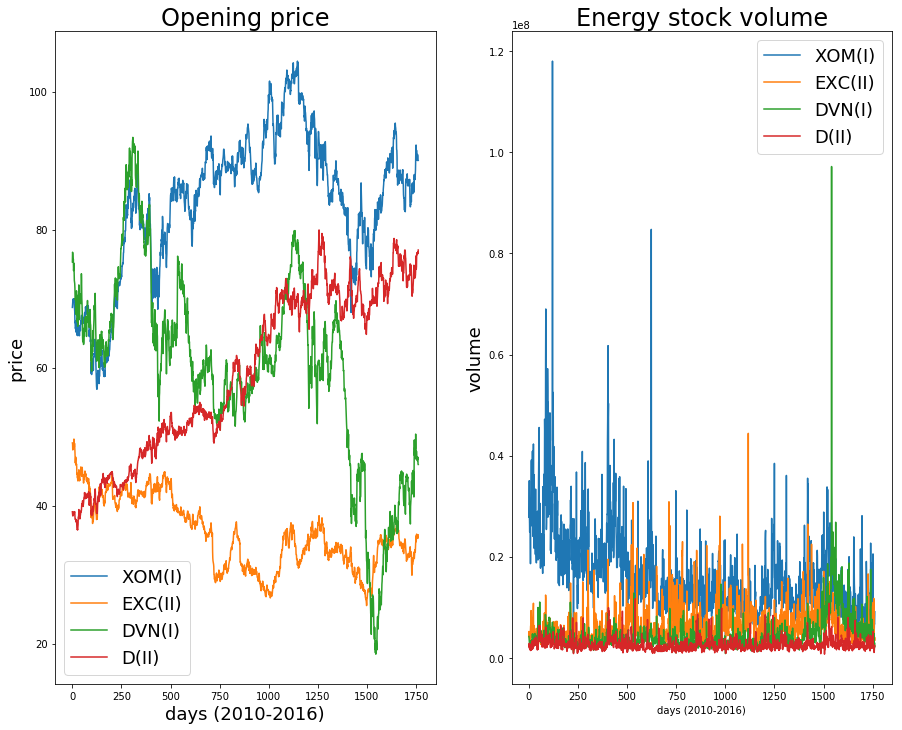

In [28]:
plt.figure(figsize=(15, 12));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'XOM'].open.values, label='XOM(I)')
plt.plot(df[df.symbol == 'EXC'].open.values, label='EXC(II)')

plt.plot(df[df.symbol == 'DVN'].open.values, label='DVN(I)')
plt.plot(df[df.symbol == 'D'].open.values, label='D(II)')
plt.title('Opening price',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('price',fontsize=18)
plt.legend(loc='best',fontsize=18)
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'XOM'].volume.values, label='XOM(I)')
plt.plot(df[df.symbol == 'EXC'].volume.values,  label='EXC(II)')

plt.plot(df[df.symbol == 'DVN'].volume.values,  label='DVN(I)')
plt.plot(df[df.symbol == 'D'].volume.values, label='D(II)')

plt.title('Energy stock volume',fontsize=24)
plt.xlabel('days (2010-2016)')
plt.ylabel('volume',fontsize=18)
plt.legend(loc='best',fontsize=18);

# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [27]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'XOM'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


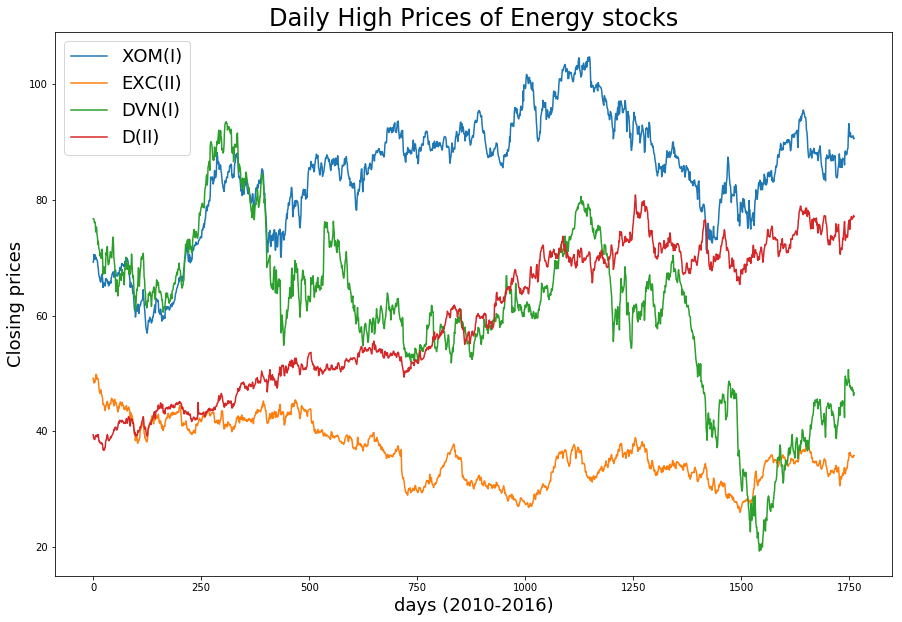

In [29]:
plt.figure(figsize=(15, 10));
plt.plot(df[df.symbol == 'XOM'].high.values, label='XOM(I)')
plt.plot(df[df.symbol == 'EXC'].high.values, label='EXC(II)')

plt.plot(df[df.symbol == 'DVN'].high.values, label='DVN(I)')
plt.plot(df[df.symbol == 'D'].high.values,  label='D(II)')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('Daily High Prices of Energy stocks',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('Closing prices',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.show()

# 4. RNN <a class="anchor" id="4-bullet"></a> 



In [10]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.099737/0.078118
4.99 epochs: MSE train/valid = 0.000532/0.001029
9.97 epochs: MSE train/valid = 0.000640/0.001017
14.96 epochs: MSE train/valid = 0.000506/0.000847
19.94 epochs: MSE train/valid = 0.000370/0.000740
24.93 epochs: MSE train/valid = 0.000459/0.000723
29.91 epochs: MSE train/valid = 0.000346/0.000680
34.90 epochs: MSE train/valid = 0.000317/0.000636
39.89 epochs: MSE train/valid = 0.000296/0.000584
44.87 epochs: MSE train/valid = 0.000299/0.000566
49.86 epochs: MSE train/valid = 0.000281/0.000564
54.84 epochs: MSE train/valid = 0.000421/0.000643
59.83 epochs: MSE train/valid = 0.000287/0.000567
64.81 epochs: MSE train/valid = 0.000257/0.000531
69.80 epochs: MSE train/valid = 0.000276/0.000547
74.78 epochs: MSE train/valid = 0.000345/0.000547
79.77 epochs: MSE train/valid = 0.000309/0.000580
84.76 epochs: MSE train/valid = 0.000269/0.000542
89.74 epochs: MSE train/valid = 0.000247/0.000523
94.73 epochs: MSE train/valid = 0.000248/0.000527
99.

# RNN Predictions <a class="anchor" id="5-bullet"></a> 

In [11]:
y_train.shape

(1394, 4)

correct sign prediction for close - open price for train/valid/test: 0.60/0.57/0.56


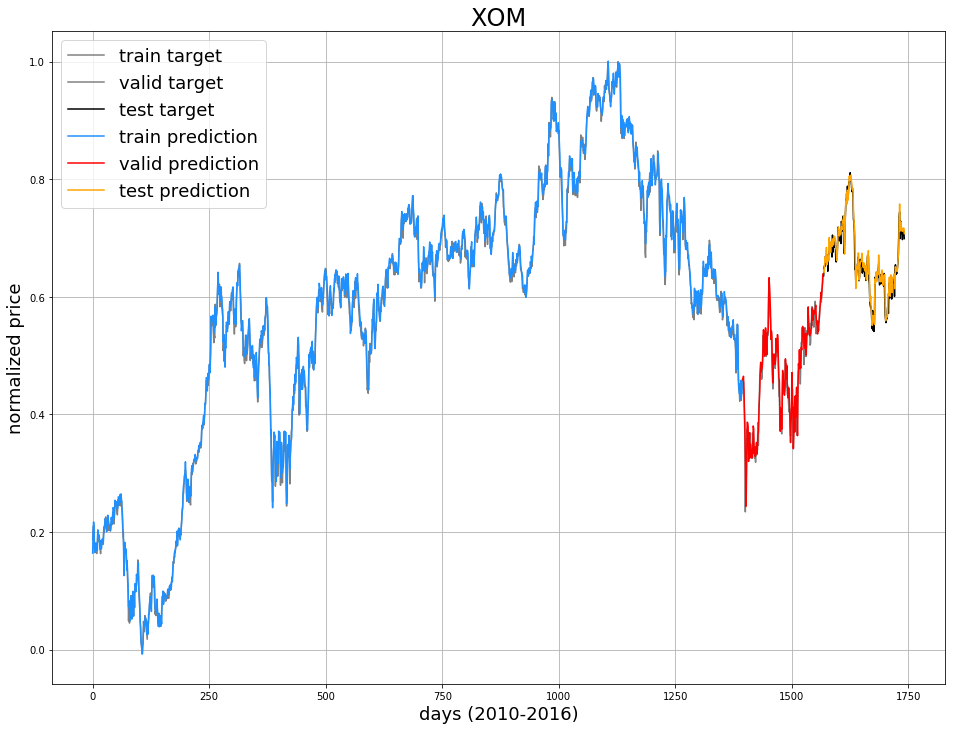

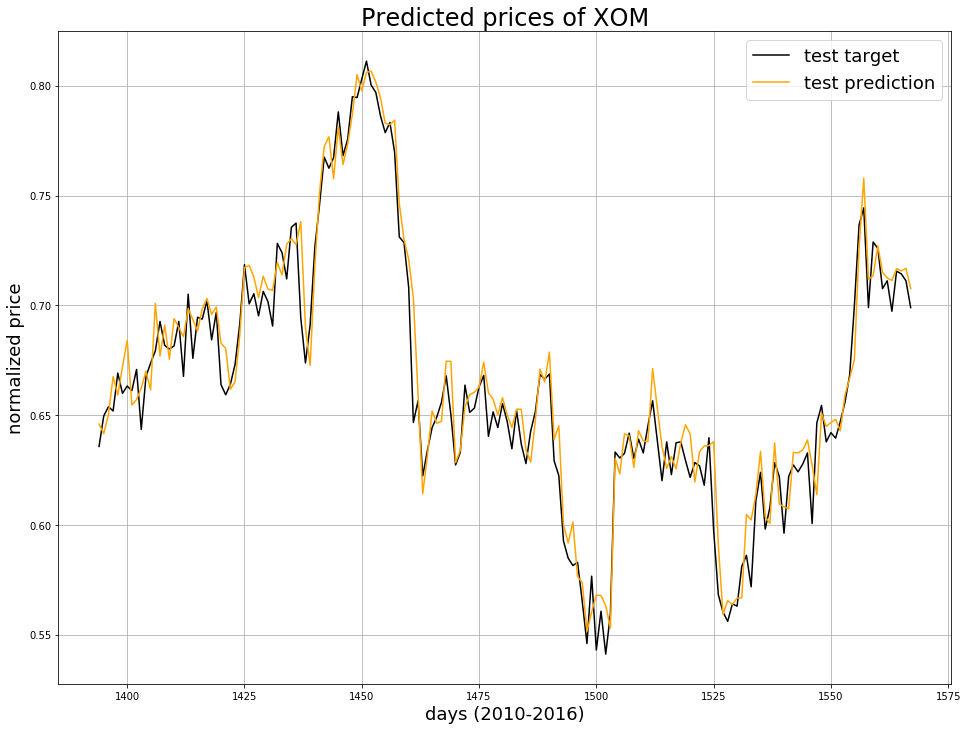

In [12]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(16, 12));
#plt.subplot(2,1,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='gray', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='dodgerblue',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='red', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='test prediction')

plt.title('XOM',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('normalized price',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()

#plt.subplot(2,1,2);
plt.figure(figsize=(16, 12));

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='test prediction')

plt.title('Predicted prices of XOM',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('normalized price',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# 5. LSTM

In [13]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                  activation=tf.nn.leaky_relu, use_peepholes = True)
          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.335946/0.199398
4.99 epochs: MSE train/valid = 0.001576/0.002362
9.97 epochs: MSE train/valid = 0.000972/0.001758
14.96 epochs: MSE train/valid = 0.000844/0.001519
19.94 epochs: MSE train/valid = 0.000761/0.001352
24.93 epochs: MSE train/valid = 0.000479/0.001028
29.91 epochs: MSE train/valid = 0.000381/0.000831
34.90 epochs: MSE train/valid = 0.000332/0.000727
39.89 epochs: MSE train/valid = 0.000613/0.000807
44.87 epochs: MSE train/valid = 0.000281/0.000605
49.86 epochs: MSE train/valid = 0.000284/0.000592
54.84 epochs: MSE train/valid = 0.000370/0.000654
59.83 epochs: MSE train/valid = 0.000401/0.000639
64.81 epochs: MSE train/valid = 0.000360/0.000606
69.80 epochs: MSE train/valid = 0.000391/0.000605
74.78 epochs: MSE train/valid = 0.000271/0.000542
79.77 epochs: MSE train/valid = 0.000259/0.000530
84.76 epochs: MSE train/valid = 0.000300/0.000542
89.74 epochs: MSE train/valid = 0.000316/0.000542
94.73 epochs: MSE train/valid = 0.000264/0.000529
99.

correct sign prediction for close - open price for train/valid/test: 0.61/0.61/0.60


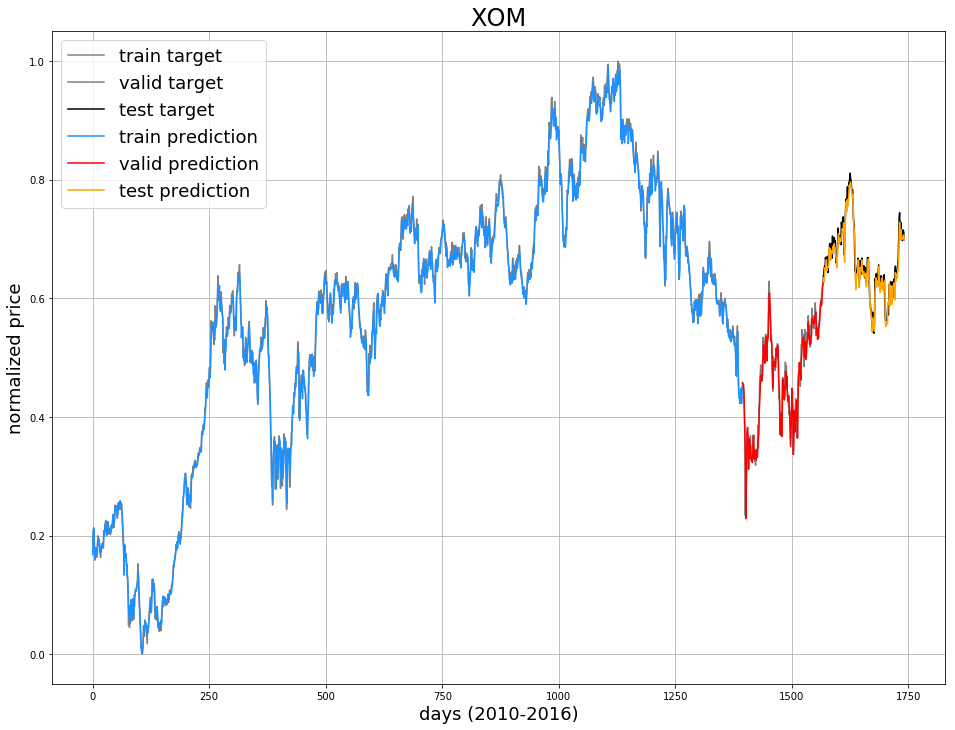

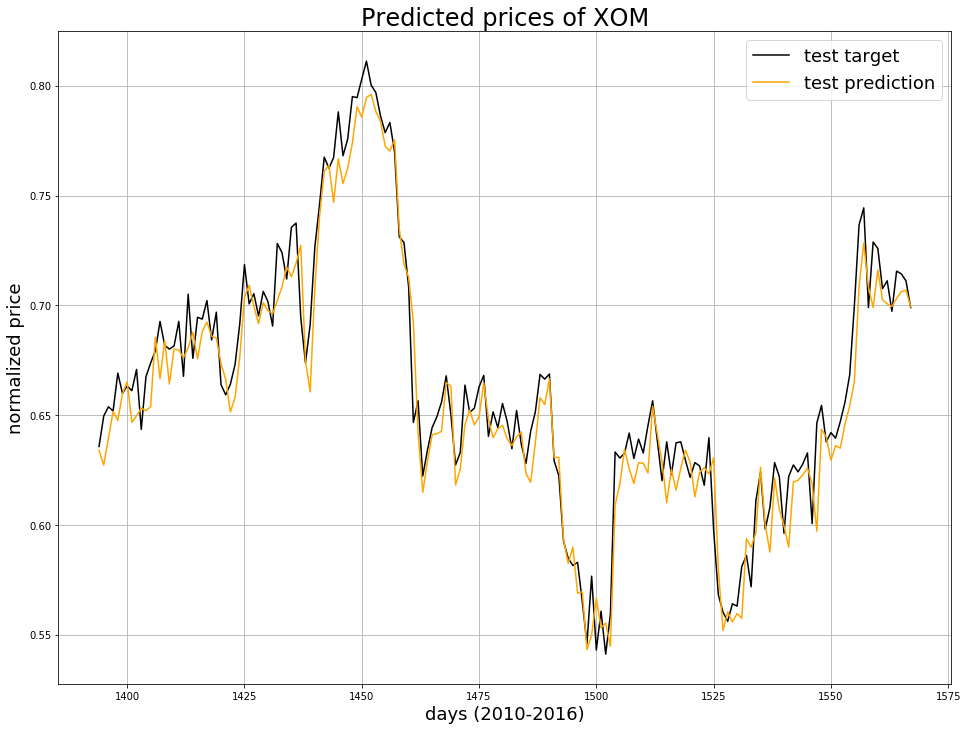

In [14]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(16, 12));
#plt.subplot(2,1,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='gray', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='dodgerblue',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='red', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='test prediction')

plt.title('XOM',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('normalized price',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()

#plt.subplot(2,1,2);
plt.figure(figsize=(16, 12));

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='test prediction')

plt.title('Predicted prices of XOM',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('normalized price',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# GRU

In [15]:

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.251895/0.149071
4.99 epochs: MSE train/valid = 0.001514/0.002297
9.97 epochs: MSE train/valid = 0.001089/0.001640
14.96 epochs: MSE train/valid = 0.000471/0.000968
19.94 epochs: MSE train/valid = 0.000380/0.000782
24.93 epochs: MSE train/valid = 0.000382/0.000714
29.91 epochs: MSE train/valid = 0.000362/0.000660
34.90 epochs: MSE train/valid = 0.000279/0.000559
39.89 epochs: MSE train/valid = 0.000272/0.000527
44.87 epochs: MSE train/valid = 0.000259/0.000523
49.86 epochs: MSE train/valid = 0.000404/0.000596
54.84 epochs: MSE train/valid = 0.000388/0.000594
59.83 epochs: MSE train/valid = 0.000256/0.000506
64.81 epochs: MSE train/valid = 0.000318/0.000566
69.80 epochs: MSE train/valid = 0.000267/0.000514
74.78 epochs: MSE train/valid = 0.000252/0.000490
79.77 epochs: MSE train/valid = 0.000263/0.000491
84.76 epochs: MSE train/valid = 0.000253/0.000497
89.74 epochs: MSE train/valid = 0.000427/0.000614
94.73 epochs: MSE train/valid = 0.000332/0.000569
99.

ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 10));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('XOM prediction by GRU')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices of XOM')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


correct sign prediction for close - open price for train/valid/test: 0.55/0.59/0.43


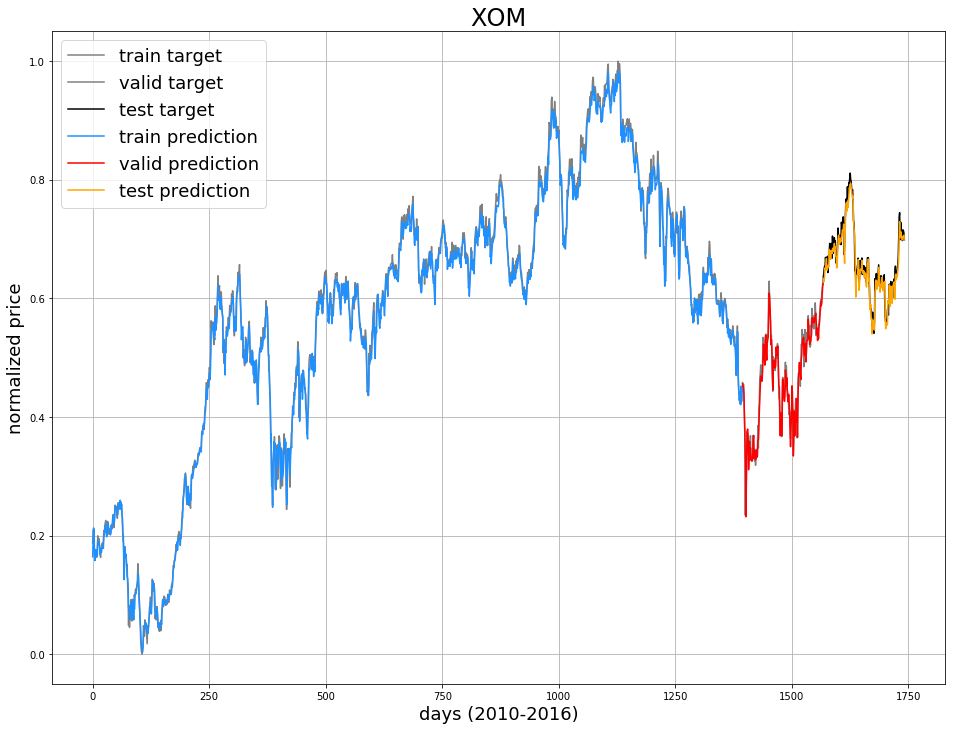

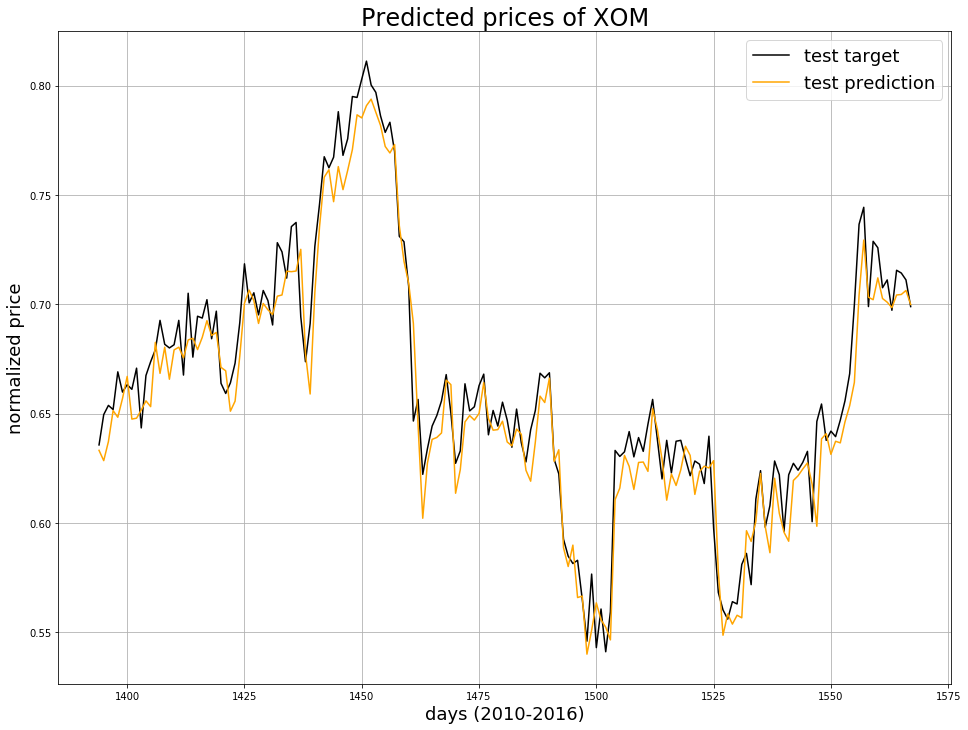

In [17]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(16, 12));
#plt.subplot(2,1,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='gray', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='dodgerblue',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='red', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='test prediction')

plt.title('XOM',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('normalized price',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()

#plt.subplot(2,1,2);
plt.figure(figsize=(16, 12));

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='orange', label='test prediction')

plt.title('Predicted prices of XOM',fontsize=24)
plt.xlabel('days (2010-2016)',fontsize=18)
plt.ylabel('normalized price',fontsize=18)
plt.legend(loc='best',fontsize=18)
plt.grid()

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


# References:

https://www.kaggle.com/code/raoulma/ny-stock-price-prediction-rnn-lstm-gru

https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook